In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from sklearn.svm import SVC
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
import scipy.io


## Load and visualize data

In [2]:
mat = scipy.io.loadmat('linear_svm.mat')
X_train = mat["X_train"]
X_test = mat["X_test"]
y_train = mat["labels_train"]
y_test = mat["labels_test"]

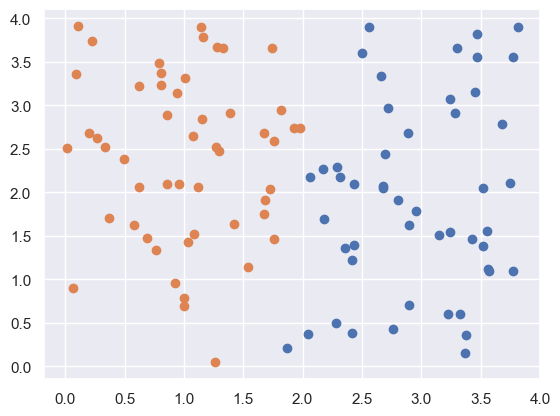

In [4]:
plt.scatter(X_train[y_train.reshape(-1,)==1,0], X_train[y_train.reshape(-1,)==1,1])
plt.scatter(X_train[y_train.reshape(-1,)==-1,0], X_train[y_train.reshape(-1,)==-1,1])

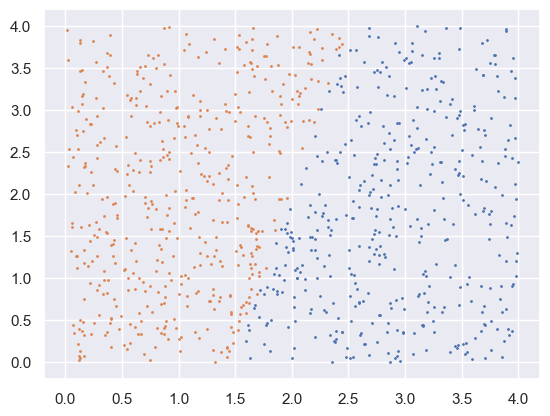

In [8]:
plt.scatter(X_test[y_test.reshape(-1,)==1,0], X_test[y_test.reshape(-1,)==1,1], s=1)
plt.scatter(X_test[y_test.reshape(-1,)==-1,0], X_test[y_test.reshape(-1,)==-1,1], s=1)

## Define SVM problem and solve it with CVXOPT
Soft-margin formulation of the problem

In [14]:
C = 1
X_dash = y_train * X_train
H = np.dot(X_dash , X_dash.T)
m,n = X_train.shape
y_train = y_train.reshape(-1,1) * 1.


Q = cvxopt_matrix(H)
p = cvxopt_matrix(-np.ones((m, 1)))
G = cvxopt_matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
A = cvxopt_matrix(y_train.reshape(1, -1))
b = cvxopt_matrix(np.zeros(1))

#Run solver
sol = cvxopt_solvers.qp(Q, p, G, h, A, b)
alphas = np.array(sol['x'])

     pcost       dcost       gap    pres   dres
 0: -2.2709e+01 -1.8401e+02  8e+02  2e+00  1e-14
 1: -1.4283e+01 -9.9540e+01  1e+02  3e-01  2e-14
 2: -8.1787e+00 -2.2620e+01  2e+01  3e-02  1e-14
 3: -9.0522e+00 -1.1424e+01  3e+00  4e-03  1e-14
 4: -9.5345e+00 -1.0104e+01  7e-01  1e-03  1e-14
 5: -9.6814e+00 -9.7764e+00  1e-01  1e-04  2e-14
 6: -9.7126e+00 -9.7238e+00  1e-02  1e-05  1e-14
 7: -9.7165e+00 -9.7168e+00  4e-04  2e-07  1e-14
 8: -9.7166e+00 -9.7166e+00  5e-06  2e-09  1e-14
Optimal solution found.


In [16]:
# Extract parameters w and b
w = ((y_train * alphas).T @ X_train).reshape(-1,1)
S = (alphas > 1e-4).flatten()
b = y_train[S] - np.dot(X_train[S], w)

#Display results
print('Alphas = ',alphas[alphas > 1e-4])
print('w = ', w.flatten())
print('b = ', b[0])


Alphas =  [0.99999982 0.99999996 0.99999953 0.99999987 0.99999989 0.99999987
 0.9999996  0.02624555 0.99999984 0.99999973 0.46074646 0.99999996
 0.48697136 0.99999997 0.99999996 0.99999997 0.99999995]
w =  [ 3.20741932 -0.47668764]
b =  [-5.5347303]


In [11]:
# Train a linear SVM using sklearn for comparison

clf = SVC(C = 10, kernel = 'linear')
clf.fit(X_train, y_train.ravel()) 

print('w = ',clf.coef_)
print('b = ',clf.intercept_)

w =  [[ 4.86901769 -0.91539757]]
b =  [-7.8904275]


## Evaluate model
On test set

In [17]:
print("************ Accuracy *****************")
(np.sign(np.matmul(X_test, w) + b[0]) == y_test).sum() / y_test.shape[0]

************ Accuracy *****************


0.9655555555555555

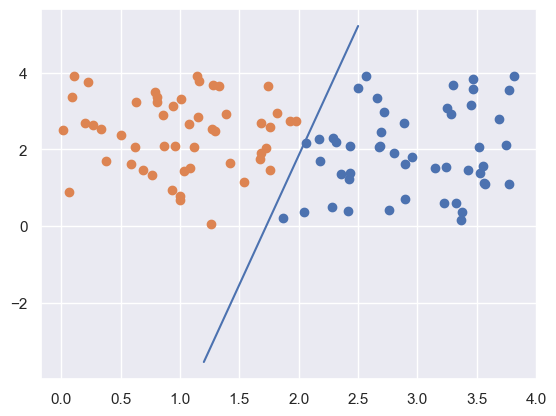

In [19]:
# Plot separation surface
plt.scatter(X_train[y_train.reshape(-1,)==1,0], X_train[y_train.reshape(-1,)==1,1])
plt.scatter(X_train[y_train.reshape(-1,)==-1,0], X_train[y_train.reshape(-1,)==-1,1])
plt.plot(np.linspace(1.2,2.5), np.linspace(1.2,2.5) * (-w[0]/w[1]) - b[0]/w[1])